To explore time series models, we will continue with the Rossmann sales data. This data set has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.

In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time. Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day? week? month?

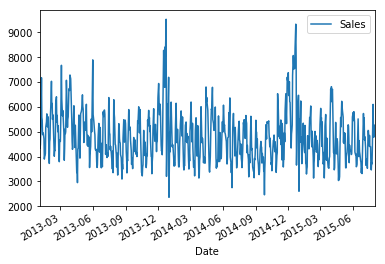

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# Load the data and set the DateTime index
# "Store","DayOfWeek","Date","Sales","Customers","Open","Promo","StateHoliday","SchoolHoliday"
# 1,5,2015-07-31,5263,555,1,1,"0","1"
data = pd.read_csv("../../../data/rossmann.csv",
                   dtype = {"Store": np.int16,
                            "DayOfWeek": np.int8,
                            "Date": object,
                            "Sales": np.int64,
                            "Customers": np.int16,
                            "Open": np.int8,
                            "Promo": np.int8,
                            "StateHoliday": object,
                            "SchoolHoliday": np.int8},
                   index_col = "Date",
                   date_parser = lambda date: pd.to_datetime(date),
                   skipinitialspace = True)

# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open == 1]

# Plot the sales over time
store1_open_data[["Sales"]].plot()
plt.show()

**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [2]:
store1_data.Sales.autocorr(lag = 1) # -0.12

-0.12732514339140216

In [3]:
store1_data.Sales.autocorr(lag = 2) # -0.03

-0.034787155707946937

Pandas and statsmodels both provide convenience plots for autocorrelations.

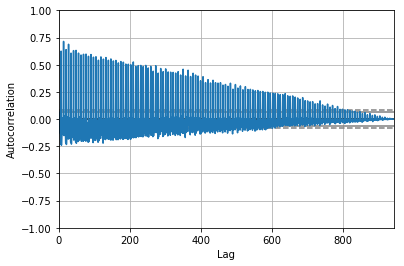

In [4]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_data.Sales)
plt.show()

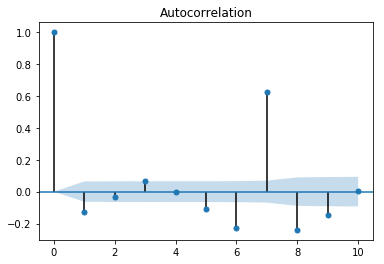

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_data.Sales, lags = 10)
plt.show()

**Check**: What caused the spike at 7?

# ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model.

In [6]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[["Sales"]].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Thu, 23 Mar 2017   AIC                          12540.651
Time:                        11:40:34   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000      4599.969  4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000         0.631     0.733
                                    Roots       

In [7]:
model = ARMA(store1_sales_data, (2, 0)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Thu, 23 Mar 2017   AIC                          12542.063
Time:                        11:40:34   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.9861     85.262     55.863      0.000      4595.876  4930.096
ar.L1.Sales     0.6634      0.036     18.537      0.000         0.593     0.734
ar.L2.Sales     0.0275      0.036      0.767    

Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

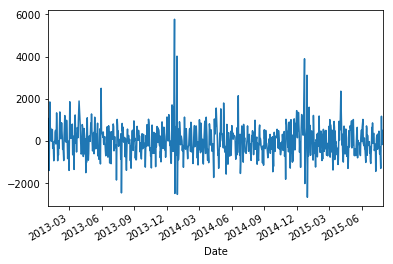

In [8]:
model.resid.plot()
plt.show()

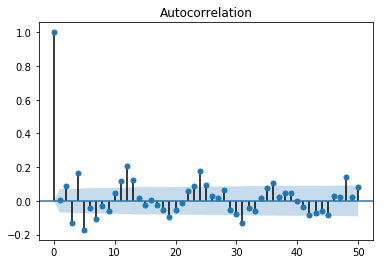

In [9]:
plot_acf(model.resid, lags = 50)
plt.show()

Because of the errors, it does not look like an AR model is good enough -- the data is not stationary. So let's expand to an `ARMA` model.

In [10]:
model = ARMA(store1_sales_data, (1, 1)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Thu, 23 Mar 2017   AIC                          12542.223
Time:                        11:40:35   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4763.2676     84.704     56.234      0.000      4597.250  4929.285
ar.L1.Sales     0.6979      0.035     20.095      0.000         0.630     0.766
ma.L1.Sales    -0.0294      0.045     -0.653    

In [11]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (2, 0, 2)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 2)   Log Likelihood               -6243.725
Method:                       css-mle   S.D. of innovations            716.957
Date:                Thu, 23 Mar 2017   AIC                          12499.449
Time:                        11:40:35   BIC                          12527.413
Sample:                    07-31-2015   HQIC                         12510.204
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4760.9462     75.652     62.933      0.000      4612.672  4909.220
ar.L1.Sales    -0.2277      0.056     -4.064      0.000        -0.338    -0.118
ar.L2.Sales     0.4689      0.057      8.271    

In [12]:
model = ARIMA(store1_sales_data, (2, 1, 2)).fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6247.179
Method:                       css-mle   S.D. of innovations            725.652
Date:                Thu, 23 Mar 2017   AIC                          12506.358
Time:                        11:40:35   BIC                          12534.314
Sample:                    07-30-2015   HQIC                         12517.111
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.5079      0.387      1.313      0.189        -0.250     1.266
ar.L1.D.Sales    -0.1820      0.050     -3.661      0.000        -0.279    -0.085
ar.L2.D.Sales     0.6469      0.035     

In [13]:
model = ARIMA(store1_sales_data, (2, 1, 0)).fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6313.493
Method:                       css-mle   S.D. of innovations            792.554
Date:                Thu, 23 Mar 2017   AIC                          12634.985
Time:                        11:40:35   BIC                          12653.622
Sample:                    07-30-2015   HQIC                         12642.153
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.1286     23.604      0.005      0.996       -46.135    46.392
ar.L1.D.Sales    -0.1847      0.036     -5.155      0.000        -0.255    -0.114
ar.L2.D.Sales    -0.0178      0.036     

Auto-correlation: -0.1814


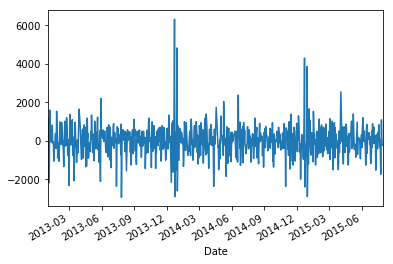

In [14]:
print("Auto-correlation: %.4f" % store1_sales_data.Sales.diff(1).autocorr(1)) #-0.1814

store1_sales_data.Sales.diff(1).plot()
plt.show()

/Users/angeloklin/anaconda3/envs/ga/lib/python2.7/site-packages/statsmodels/tsa/arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


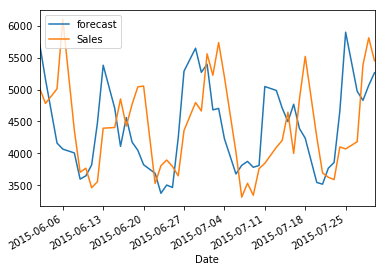

In [15]:
model.plot_predict(1, 50)
plt.show()

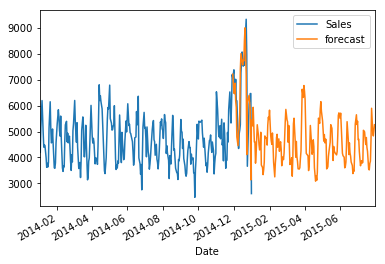

In [16]:
fig, ax = plt.subplots()
ax = store1_sales_data["2014"].plot(ax = ax)

fig = model.plot_predict(1, 200, ax = ax, plot_insample = False)

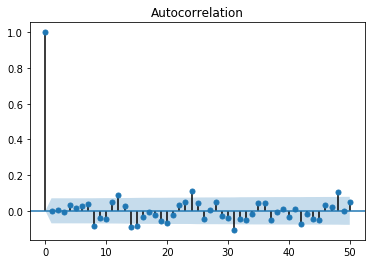

In [17]:
model = ARIMA(store1_sales_data, (7, 1, 2)).fit()
model.summary()

plot_acf(model.resid, lags = 50)
plt.show()